# Identifying temporal variation in EvoDevo data with MEFISTO

This notebook demonstrates how temporal (or spatial) covariates can be used for multimodal data integration to learn smooth latent factors using a developmental gene expression atlas comprising multiple species and organs.

In [1]:
import numpy as np
import pandas as pd
from mofapy2.run.entry_point import entry_point
import mofax
import seaborn as sns

# initialise the entry point
ent = entry_point()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


# Load data

First we will load the evodevo data containing normalized gene expression data for 5 species (groups) and 5 organs (views) as well as the developmental time information for each sample. The data as well as a pre-trained model can be downloaded from here.

In [3]:
datadir = "./"

In [ ]:
data = pd.read_csv(f"{datadir}/evodevo.csv", sep=",", index_col=0)
data

# Prepare and train MEFISTO

Next we create a MOFA object with this data with the default options.

In [ ]:
ent.set_data_options()
ent.set_data_df(data)

We can now specify additional option for the model and the training. 
See our basic python tutorial on MOFA for details. Here we specify, that we want to use 5 factor.

In [ ]:
ent.set_model_options(factors=5)
ent.set_train_options()

So far, we have not yet added the time information for the samples. This is done in the next step, where we also specify options for MEFISTO. In particular, we want to align time points between species and set warp to True using Mouse as reference. To also infer relationships between species we set model_groups to True.

In [ ]:
times = [data[['sample', 'time', 'group']].drop_duplicates().set_index('sample').loc[np.concatenate(ent.data_opts['samples_names'])].query('group == @g').time.values.reshape(-1, 1) for g in ent.data_opts['groups_names']]
idx = np.where(ent.data_opts['groups_names'] == 'Mouse')

In [ ]:
idx = ent.data_opts['groups_names'].index("Mouse")

In [ ]:
ent.set_covariates(times, covariates_names="time")
ent.set_smooth_options(warping=True, warping_ref = idx, model_groups = True)

Now we are ready to use MEFISTO with this object and save the results in a speciefied location. As this can take up to 15min, we provide a pre-trained model below.

In [ ]:
ent.build()
ent.run()

In [ ]:
## To interpolate factor values
ent.predict_factor(new_covariates=np.arange(1, 15).reshape(-1, 1))
ent.save("evodevo_model.hdf5")

# Downstream analysis

For downstream analysis we can either use R (package MOFA2) or the Python package mofax. Here we will proceed in Python and first load the pre-trained model generated by the above steps.

In [5]:
m = mofax.mofa_model(f"{datadir}/COVID_early_late_death_model_iteration1_MEFISTO_day_of_symptoms.hdf5")
m

MOFA+ model: COVID early late death model iteration1 MEFISTO day of symptoms
Samples (cells): 52
Features: 202
Groups: single_group (52)
Views: Clinical (17), IMC (113), Luminex (72)
Factors: 5
Expectations: Sigma, W, Z

MEFISTO:
Covariates available: Average_Day_of_Symptoms

Groups correspond to species here and views correspond to organs:

In [ ]:
print(f"""\
Samples: {m.shape[0]}
Features: {m.shape[1]}
Species: {', '.join(m.groups)}
Organs: {', '.join(m.views)}
""")

# Variance explained

First, we can take a look at the variance explained by each of the inferred factors per organ and species.

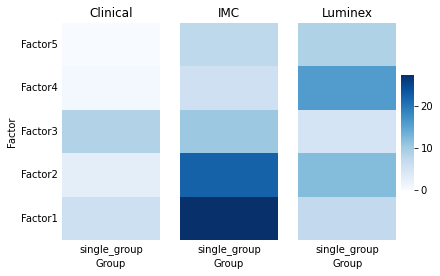

In [16]:
mofax.plot_r2(m, cmap="Blues")

# Visualization in the factor space

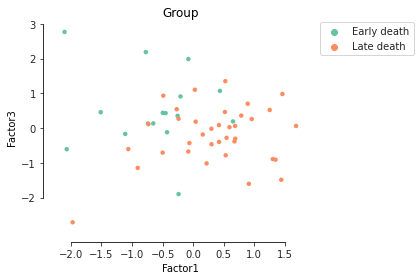

In [12]:
#Using the first two factors, we can project the samples into a 2-dimensional space.
mofax.plot_factors_scatter(m, x=0, y=2, color=["Group"]);

# Latent factors versus common developmental time

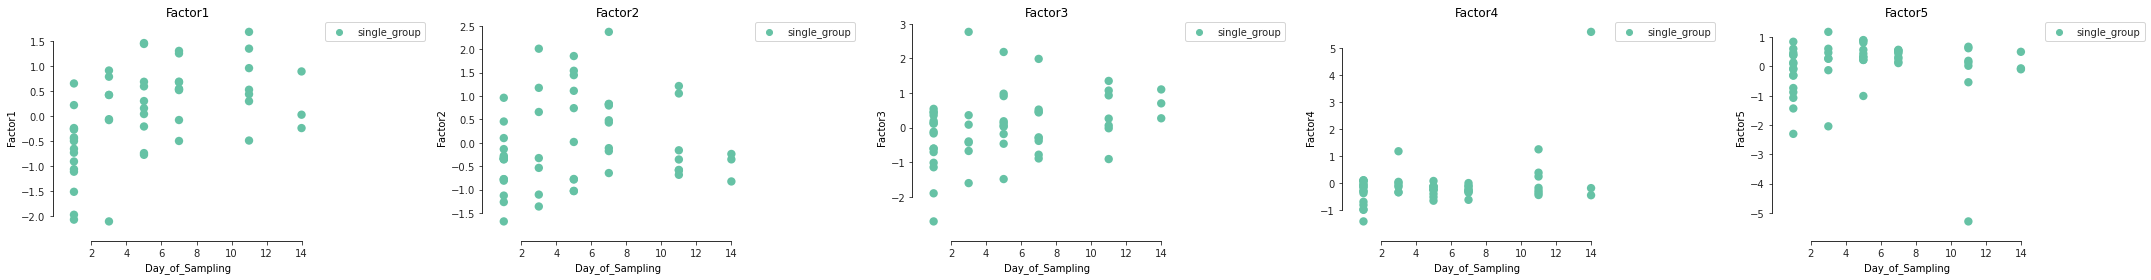

In [13]:
#We can plot the latent processes along the inferred common developmental time.
#Before alignment:
mofax.plot_factors_scatter(m, x="Day_of_Sampling", y=range(m.nfactors), 
                           ncols=5, size=70);

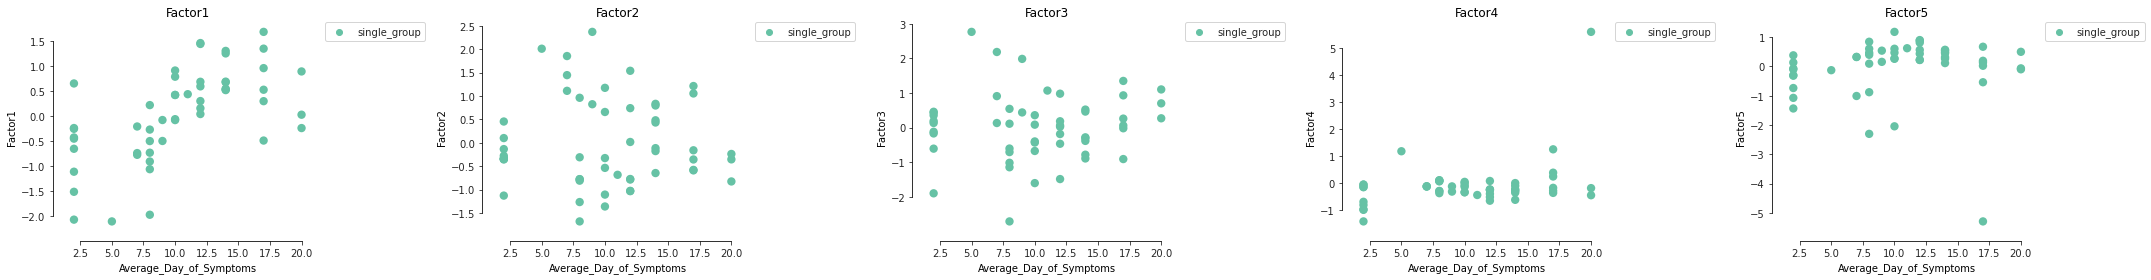

In [14]:
#After alignment:
mofax.plot_factors_scatter(m, x="Average_Day_of_Symptoms", y=range(m.nfactors), 
                           ncols=5, size=70);

# Interpolation

Using the underlying Gaussian process for each factor we can interpolate to unseen time points for species that are missing data in these time points or intermediate time points.

In [ ]:
mofax.plot_interpolated_factors(m, factors=range(m.nfactors),
                                ncols=5, size=70);

In [ ]:
#Uncertainties and observed data points on these plots can be hidden with only_mean=True and show_observed=False:
mofax.plot_interpolated_factors(m, factors=["Factor4", "Factor5"], size=70, only_mean=True);

mofax.plot_interpolated_factors(m, factors=["Factor4", "Factor5"], size=70, show_observed=False);

# Alignment

In [ ]:
#We can also take a look at the learnt alignemnt.
mofax.plot_factors_scatter(m, x="time", y="time_transformed");

# Smoothness and sharedness of factors

In addition to the factor values and the alignment the model also inferred an underlying Gaussian process that generated these values. By looking into it we can extract information on the smoothness of each factor, i.e. how smoothly it varies along developmental time, as well as the sharedness of each factor, i.e. how much the species (groups) show the same underlying developmental pattern and how the shape of their developmental trajectory related to a given developmental module (Factor) clusters between species.

Smoothness
The scale parameters of the Gaussian process capture the smoothness of the model. We will visualize them with bar plots where more colour means more smoothness:

<AxesSubplot:xlabel='Smoothness', ylabel='Factor'>

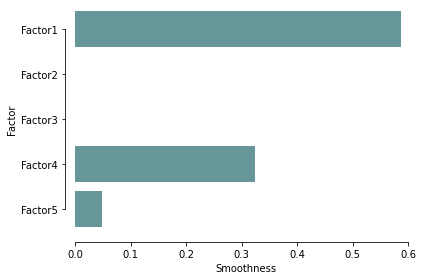

In [16]:
mofax.plot_smoothness(m)

Sharedness
The group kernel of the Gaussian process can give us insights into the extent to which a temporal pattern is shared across species for the developmental module captured by each process.
First factors (factors 1, 2, and 3) seem to describe processed conserved across species while the last two factors show species-specific clusters:

<AxesSubplot:title={'center':'Factor5'}, xlabel='Group', ylabel='Group'>

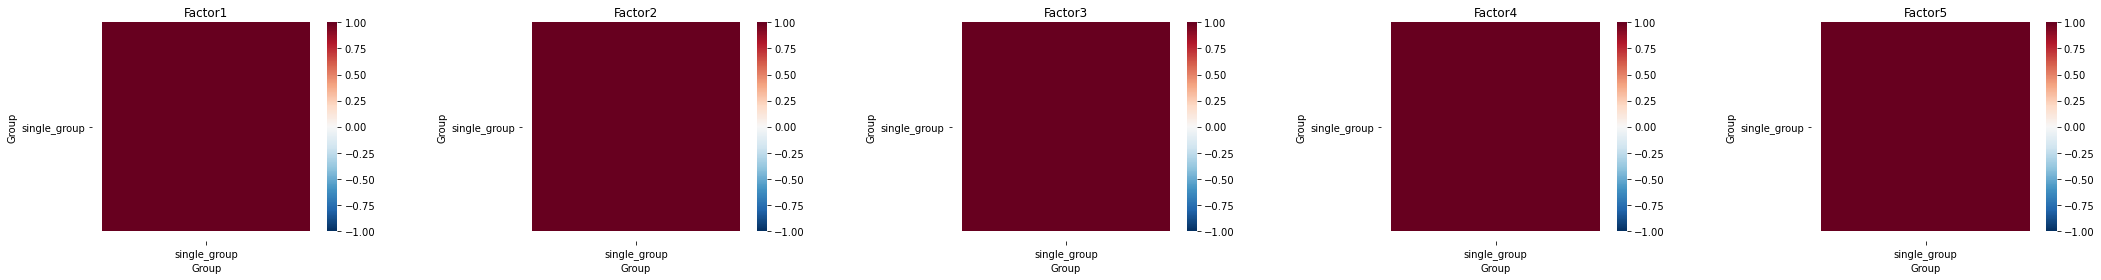

In [17]:
mofax.plot_group_kernel(m, ncols=5)

ValueError: Linkage must be computed on at least two observations.

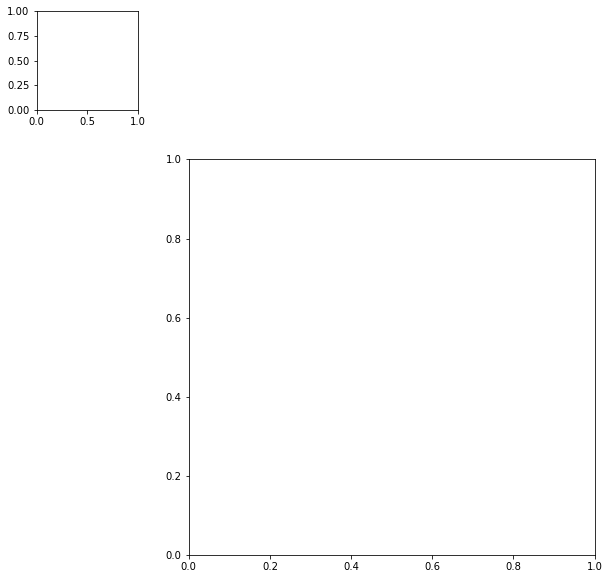

In [18]:
mofax.plot_group_kernel(m, ncols=5, factors="Factor5")

In [19]:
mofax.plot_sharedness(m)

AssertionError: Multiple groups are required to determine sharedness

Weights
To gain insights into the molecular signatures underlying each factor, we can investigate the weights of each factor.

<AxesSubplot:title={'center':'Clinical'}, xlabel='factor', ylabel='feature'>

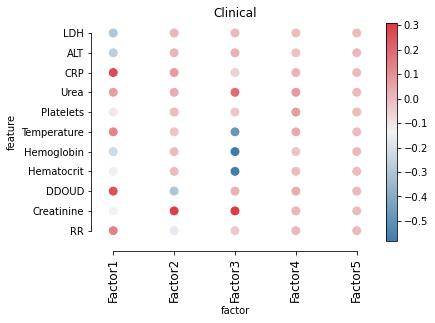

In [28]:
mofax.plot_weights_dotplot(m, view="Clinical", n_features=3, 
                           yticklabels_size=10, xticklabels_size=12, size=100)

In [14]:
cols4delivery = {"Early death": "#e6ab02", "Late death": "#d95f02"}

<AxesSubplot:title={'center':'Factor2'}, xlabel='Average_Day_of_Symptoms', ylabel='Factor2'>

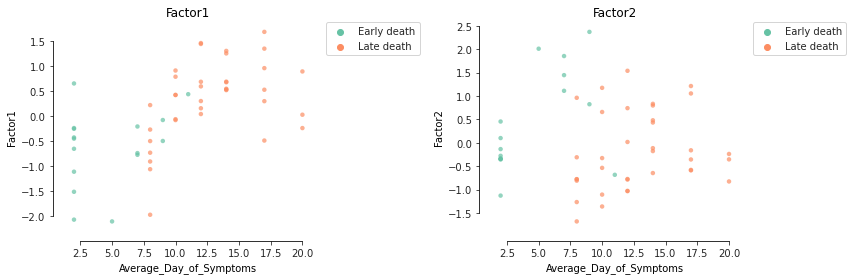

In [17]:
mofax.plot_factors(m, x="Average_Day_of_Symptoms", y=[0, 1], 
                   color="Group", alpha=.7)